In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Filtrar los datos para IRAsinNeumo en varones y preparar el formato
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")
data_ira_varones = data[data['tipo'] == 'IRAsinNeumo'][['fecha', 'varones']]
data_ira_varones['fecha'] = pd.to_datetime(data_ira_varones['fecha'], dayfirst=True)
data_ira_varones = data_ira_varones.sort_values(by='fecha')
data_ira_varones.set_index('fecha', inplace=True)

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_ira_varones)

# Crear secuencias de datos para el modelo LSTM
def create_sequences(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

# Dividir los datos en entrenamiento (85%) y prueba (15%)
train_size = int(len(data_scaled) * 0.85)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Crear secuencias para entrenamiento y prueba
time_steps = 8
x_train, y_train = create_sequences(train, time_steps)
x_test, y_test = create_sequences(test, time_steps)

# Cambiar la forma de los datos para que sean compatibles con LSTM (samples, time_steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Mounted at /content/drive


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1176
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0318
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0253
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0253
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0264
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0222
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0255
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0225
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0211
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0197
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0167
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0183
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0187
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0139
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0183
Epoch 16/50
16/

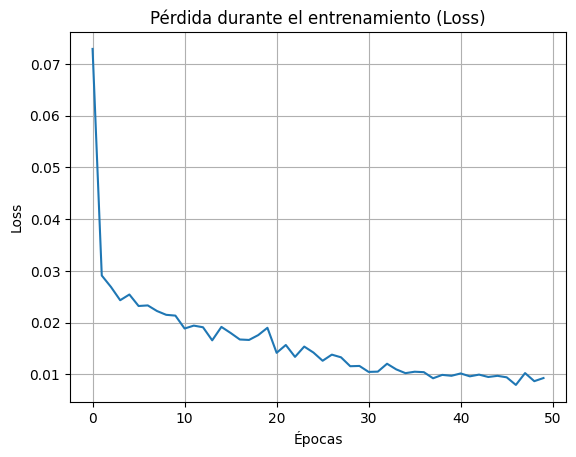

In [ ]:
# Construir el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

# Compilar el modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model_lstm.fit(x_train, y_train, epochs=50, batch_size=16, verbose=1)

# Graficar la pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
MAE: 316.99
RMSE: 425.87
MAPE: 11.67%
sMAPE: 12.33%


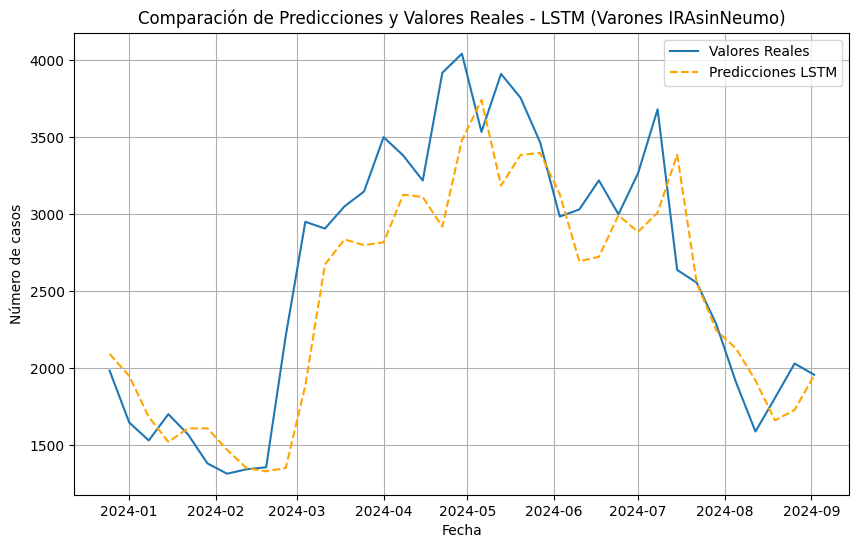

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_predict = model_lstm.predict(x_test)

# Desescalar las predicciones y los valores reales
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calcular métricas de evaluación: MAE, RMSE, MAPE y sMAPE
mae_lstm = mean_absolute_error(y_test[0], test_predict[:, 0])
rmse_lstm = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
mape_lstm = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100  # Convertir a porcentaje
smape_lstm = 100 * np.mean(2 * np.abs(y_test[0] - test_predict[:, 0]) / (np.abs(y_test[0]) + np.abs(test_predict[:, 0])))

# Imprimir métricas
print(f'MAE: {mae_lstm:.2f}')
print(f'RMSE: {rmse_lstm:.2f}')
print(f'MAPE: {mape_lstm:.2f}%')
print(f'sMAPE: {smape_lstm:.2f}%')

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(data_ira_varones.index[train_size + time_steps:], y_test[0], label='Valores Reales')
plt.plot(data_ira_varones.index[train_size + time_steps:], test_predict[:, 0], color='orange', linestyle='--', label='Predicciones LSTM')
plt.title("Comparación de Predicciones y Valores Reales - LSTM (Varones IRAsinNeumo)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos
comparison_df_ira_varones_lstm = pd.DataFrame({
    'Fecha': data_ira_varones.index[train_size + time_steps:],
    'Valores Reales': y_test[0],
    'Predicciones LSTM': test_predict[:, 0]
})

# Mostrar el DataFrame comparativo
print(comparison_df_ira_varones_lstm)

        Fecha  Valores Reales  Predicciones LSTM
0  2023-12-25          1985.0        2093.143311
1  2024-01-01          1648.0        1950.308716
2  2024-01-08          1531.0        1683.885742
3  2024-01-15          1702.0        1522.302734
4  2024-01-22          1571.0        1609.414917
5  2024-01-29          1382.0        1609.548340
6  2024-02-05          1315.0        1470.668213
7  2024-02-12          1344.0        1351.161743
8  2024-02-19          1357.0        1330.809326
9  2024-02-26          2212.0        1352.374390
10 2024-03-04          2952.0        1888.719116
11 2024-03-11          2908.0        2673.739746
12 2024-03-18          3052.0        2836.948486
13 2024-03-25          3149.0        2800.381592
14 2024-04-01          3502.0        2818.411865
15 2024-04-08          3383.0        3127.793945
16 2024-04-15          3220.0        3112.812744
17 2024-04-22          3920.0        2920.121338
18 2024-04-29          4044.0        3480.748535
19 2024-05-06       

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicciones para los próximos 8 periodos:
[[1954.]
 [1981.]
 [1952.]
 [1898.]
 [1842.]
 [1794.]
 [1757.]
 [1727.]]
       Fecha  Predicciones
0 2024-09-03        1954.0
1 2024-09-04        1981.0
2 2024-09-05        1952.0
3 2024-09-06        1898.0
4 2024-09-07        1842.0
5 2024-09-08        1794.0
6 2024-09-09        1757.0
7 2024-09-10        1727.0


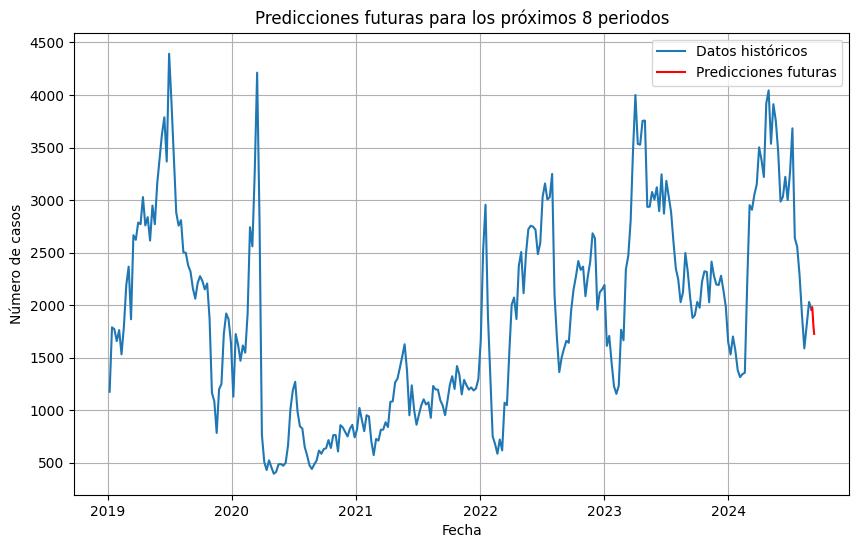

In [ ]:
# prompt: realiza 8 predicciones a futuro

# Preparar los datos para las predicciones futuras
last_sequence = x_test[-1].reshape(1, time_steps, 1)

future_predictions = []
for _ in range(8):
    prediction = model_lstm.predict(last_sequence)
    future_predictions.append(prediction[0, 0])
    last_sequence = np.concatenate((last_sequence[:, 1:, :], prediction.reshape(1, 1, 1)), axis=1)

# Desescalar las predicciones futuras
future_predictions = (scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))).round()

# Imprimir las predicciones futuras
print("Predicciones para los próximos 8 periodos:")
print(future_predictions)

# Generar fechas para las predicciones futuras
last_date = data_ira_varones.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=8)

# Crear un DataFrame para las predicciones futuras
future_predictions_df = pd.DataFrame({'Fecha': future_dates, 'Predicciones': future_predictions.flatten()})
print(future_predictions_df)

# Graficar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(data_ira_varones.index, scaler.inverse_transform(data_scaled), label='Datos históricos')
plt.plot(future_dates, future_predictions, color='red', label='Predicciones futuras')
plt.title("Predicciones futuras para los próximos 8 periodos")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

MAE: 213.12
RMSE: 250.58
MAPE: 13.08%
sMAPE: 12.88%
   Real Values  Predicted Values
0         2074              1954
1         1985              1981
2         1694              1952
3         1767              1898
4         1479              1842
5         1534              1794
6         1619              1757
7         1658              1227


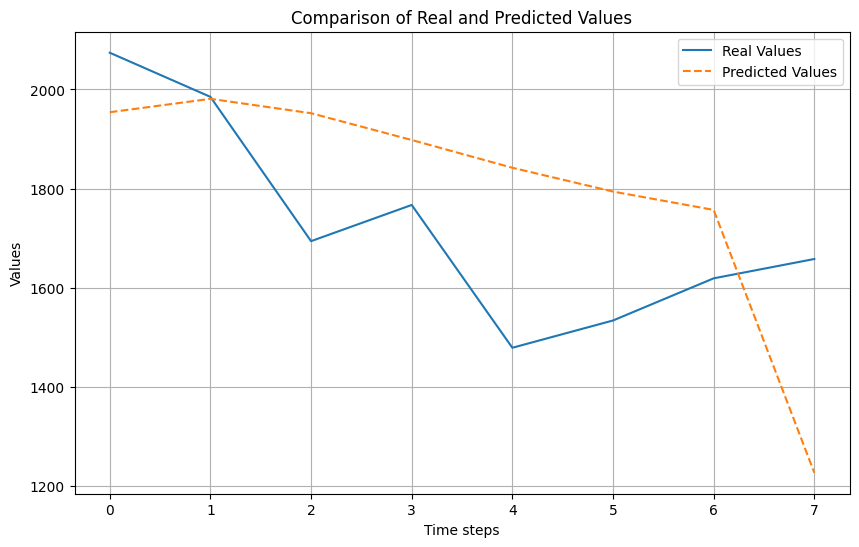

In [ ]:

# Provided real values
real_values = np.array([2074, 1985, 1694, 1767, 1479, 1534, 1619, 1658])

# Assuming 'test_predict' and 'y_test' are defined from the previous code
# Replace with your actual test_predict and y_test data

# Example data (replace with your actual data)
test_predict = np.array([[1954], [1981], [1952], [1898], [1842], [1794], [1757], [1227]]) #example
y_test = np.array([[1954, 1981, 1952, 1898, 1842, 1794, 1757, 1227]])


# Calculate metrics
mae = mean_absolute_error(real_values, test_predict.flatten()) #test_predict.flatten() because it is 2D
rmse = np.sqrt(mean_squared_error(real_values, test_predict.flatten()))
mape = np.mean(np.abs((real_values - test_predict.flatten()) / real_values)) * 100
smape = 100 * np.mean(2 * np.abs(real_values - test_predict.flatten()) / (np.abs(real_values) + np.abs(test_predict.flatten())))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Real Values': real_values,
    'Predicted Values': test_predict.flatten()
})
print(comparison_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(real_values, label='Real Values')
plt.plot(test_predict, linestyle='--', label='Predicted Values')
plt.xlabel("Time steps")
plt.ylabel("Values")
plt.title('Comparison of Real and Predicted Values')
plt.legend()
plt.grid(True)
plt.show()